# Load libraries

In [1]:
import gc

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

# Read data

In [2]:
train = pd.read_csv("../input/tabular-playground-series-mar-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-mar-2022/test.csv")

train.drop('row_id', axis=1, inplace=True)
test.drop('row_id', axis=1, inplace=True)

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

train.head()

Train shape: (848835, 5)
Test  shape: (2340, 4)


,time,x,y,direction,congestion
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60


# Data processing

In [3]:
print('## TRAIN set ##')
print(train.info())
print('\n## TEST set ##')
print(test.info())

## TRAIN set ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        848835 non-null  object
 1   x           848835 non-null  int64 
 2   y           848835 non-null  int64 
 3   direction   848835 non-null  object
 4   congestion  848835 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 32.4+ MB
None

## TEST set ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   time       2340 non-null   object
 1   x          2340 non-null   int64 
 2   y          2340 non-null   int64 
 3   direction  2340 non-null   object
dtypes: int64(2), object(2)
memory usage: 73.2+ KB
None


There are **no null values** in both train and test set

In [4]:
train.describe()

,x,y,congestion
count,848835.000000,848835.000000,848835.000000
mean,1.138462,1.630769,47.815305
std,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,35.000000
50%,1.000000,2.000000,47.000000
75%,2.000000,3.000000,60.000000
max,2.000000,3.000000,100.000000


In [5]:
#target values from 0 to 100
np.sort(train.congestion.unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [6]:
test.describe()

,x,y
count,2340.000000,2340.000000
mean,1.138462,1.630769
std,0.801649,1.089611
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
max,2.000000,3.000000


In [7]:
print('## x train/test##')
print(train.x.unique(), '/', test.x.unique())

print('\n## y train/test##')
print(train.y.unique(), '/', test.y.unique())

## x train/test##
[0 1 2] / [0 1 2]

## y train/test##
[0 1 2 3] / [0 1 2 3]


## Extract date-time features

In [8]:
train['date'] = pd.to_datetime(train['time'])
test['date'] = pd.to_datetime(test['time'])

train['day'] = train['date'].dt.day
test['day'] = test['date'].dt.day

train['year'] = train['date'].dt.year
test['year'] = test['date'].dt.year

train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

train['dayofweek'] = train['date'].dt.dayofweek
test['dayofweek'] = test['date'].dt.dayofweek

train['hour'] = train['date'].dt.hour
test['hour'] = test['date'].dt.hour

train['minute'] = train['date'].dt.minute
test['minute'] = test['date'].dt.minute

train.drop('time', inplace=True, axis=1)
test.drop('time', inplace=True, axis=1)

train.tail()

,x,y,direction,congestion,date,day,year,month,dayofweek,hour,minute
848830,2,3,NB,54,1991-09-30 11:40:00,30,1991,9,0,11,40
848831,2,3,NE,28,1991-09-30 11:40:00,30,1991,9,0,11,40
848832,2,3,SB,68,1991-09-30 11:40:00,30,1991,9,0,11,40
848833,2,3,SW,17,1991-09-30 11:40:00,30,1991,9,0,11,40
848834,2,3,WB,24,1991-09-30 11:40:00,30,1991,9,0,11,40


In [9]:
print('## year ## train/test')
print(train.year.unique(), '/', test.year.unique())

print('\n## month ## train/test')
print(train.month.unique(), '/', test.month.unique())

print('\n## day ## train/test')
print(train.day.unique(), '/', test.day.unique())

print('\n## day in month=9 ## train/test')
print(train[train.month == 9]['day'].unique(), '/', test[test.month == 9]['day'].unique())

print('\n## hour in month=9 & day=30 ## train/test')
print(train[(train.month == 9) & (train.day == 30)]['hour'].unique(), '/', test[(test.month == 9) & (test.day == 30)]['hour'].unique())

print('\n## day of week')
print(train.dayofweek.unique(), '/', test.dayofweek.unique())

print('\n## 30.09.1991 day of week')
train[(train.month == 9) & (train.day == 30)]['dayofweek'].unique()

## year ## train/test
[1991] / [1991]

## month ## train/test
[4 5 6 7 8 9] / [9]

## day ## train/test
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] / [30]

## day in month=9 ## train/test
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] / [30]

## hour in month=9 & day=30 ## train/test
[ 0  1  2  3  4  5  6  7  8  9 10 11] / [12 13 14 15 16 17 18 19 20 21 22 23]

## day of week
[0 1 2 3 4 5 6] / [0]

## 30.09.1991 day of week


array([0])

**We have to predict traffic at 30.09.1991 from 12 till 23 hours**

And we have all previous data in our train set

**30.09.1991 was a Monday**

## Direction feature

In [10]:
print('train/test')
print(train.direction.unique())
print(test.direction.unique())

train/test
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [11]:
#One-hot encoding
cols = ['direction']
train = pd.concat([train, pd.get_dummies(train[cols], prefix=cols)], axis=1)
test = pd.concat([test, pd.get_dummies(test[cols], prefix=cols)], axis=1)


print('Train shape:', train.shape)
print('Test  shape:', test.shape) 
train.head()

Train shape: (848835, 19)
Test  shape: (2340, 18)


,x,y,direction,congestion,date,day,year,month,dayofweek,hour,minute,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB
0,0,0,EB,70,1991-04-01,1,1991,4,0,0,0,1,0,0,0,0,0,0,0
1,0,0,NB,49,1991-04-01,1,1991,4,0,0,0,0,1,0,0,0,0,0,0
2,0,0,SB,24,1991-04-01,1,1991,4,0,0,0,0,0,0,0,1,0,0,0
3,0,1,EB,18,1991-04-01,1,1991,4,0,0,0,1,0,0,0,0,0,0,0
4,0,1,NB,60,1991-04-01,1,1991,4,0,0,0,0,1,0,0,0,0,0,0


# Feature engineering

In [12]:
#Only days except weekend and Friday
train = train[train.dayofweek < 4]

### hour + minutes

In [13]:
print(train.hour.unique())
train['hour_min'] = train['hour'] + (train['date'].dt.minute / 60)
test['hour_min'] = test['hour'] + (test['date'].dt.minute / 60)

train.tail()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


,x,y,direction,congestion,date,day,year,month,dayofweek,hour,minute,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB,hour_min
848830,2,3,NB,54,1991-09-30 11:40:00,30,1991,9,0,11,40,0,1,0,0,0,0,0,0,11.666667
848831,2,3,NE,28,1991-09-30 11:40:00,30,1991,9,0,11,40,0,0,1,0,0,0,0,0,11.666667
848832,2,3,SB,68,1991-09-30 11:40:00,30,1991,9,0,11,40,0,0,0,0,1,0,0,0,11.666667
848833,2,3,SW,17,1991-09-30 11:40:00,30,1991,9,0,11,40,0,0,0,0,0,0,1,0,11.666667
848834,2,3,WB,24,1991-09-30 11:40:00,30,1991,9,0,11,40,0,0,0,0,0,0,0,1,11.666667


### cong_median

In [14]:
# Compute the median congestion
cols = ['x', 'y', 'direction', 'dayofweek', 'hour', 'minute']
tmp = train[cols + ['congestion']]
train['cong_median'] = tmp.groupby(cols).transform('median')

test['cong_median'] = test.merge(tmp.groupby(cols).congestion.median().astype(int), 
                 left_on=cols,
                 right_index=True)[['congestion']].congestion

del tmp
gc.collect()
train.head()

,x,y,direction,congestion,date,day,year,month,dayofweek,hour,...,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB,hour_min,cong_median
0,0,0,EB,70,1991-04-01,1,1991,4,0,0,...,1,0,0,0,0,0,0,0,0.0,35.0
1,0,0,NB,49,1991-04-01,1,1991,4,0,0,...,0,1,0,0,0,0,0,0,0.0,29.0
2,0,0,SB,24,1991-04-01,1,1991,4,0,0,...,0,0,0,0,1,0,0,0,0.0,24.0
3,0,1,EB,18,1991-04-01,1,1991,4,0,0,...,1,0,0,0,0,0,0,0,0.0,17.0
4,0,1,NB,60,1991-04-01,1,1991,4,0,0,...,0,1,0,0,0,0,0,0,0.0,63.0


### Monday peak hours

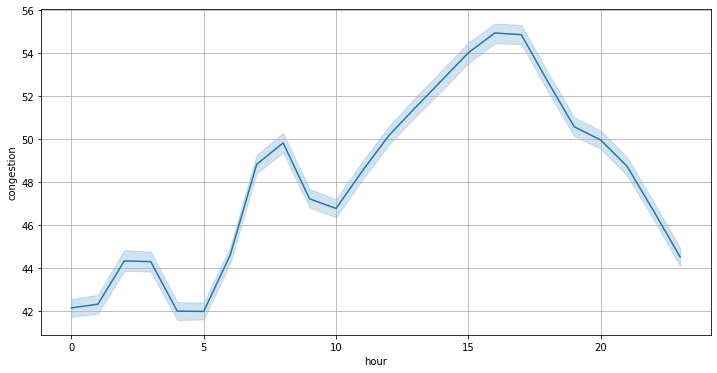

In [15]:
tmp = train[train.dayofweek == 0][['hour', 'congestion']]
plt.figure(figsize=(12,6))
sns.lineplot(x=tmp['hour'], y=tmp['congestion'])
plt.grid(which='both')
plt.show()

In [16]:
def peak_hours_monday(hour):
    if hour >= 15 and hour <=17:
        return 2
    elif hour >= 7 and hour <= 9:
        return 1
    else:
        return 0
    
train['hour_peak'] = train['hour'].apply(peak_hours_monday)
test['hour_peak'] = test['hour'].apply(peak_hours_monday)

### Seasons

In [17]:
#"""
train['season_w'] = (train['month'] == 12) | (train['month'] <= 2)
test['season_w'] = (test['month'] == 12) | (test['month'] <= 2)

train['season_sp'] = train.month.isin(range(3,6))
test['season_sp'] = test.month.isin(range(3,6))

train['season_su'] = train.month.isin(range(6,9))
test['season_su'] = test.month.isin(range(6,9))

train['season_o'] = train.month.isin(range(9,12))
test['season_o'] = test.month.isin(range(9,12))
#"""

### Only Mondays

In [18]:
train = train[train.dayofweek == 0]

### Holiday

**cv ok but lb nok**

In [19]:
#"""
import holidays

def isHoliday(date):
    countryHolidays = holidays.CountryHoliday('USA', years=date.year)
    return date in countryHolidays

train['is_holiday'] = train.apply(lambda x: isHoliday(x['date']), axis=1)
test['is_holiday'] = test.apply(lambda x: isHoliday(x['date']), axis=1)

print('\n## Train set ##')
print(train['is_holiday'].value_counts())
print('\n## Test set ##')
print(test['is_holiday'].value_counts())
#"""


## Train set ##
False    114660
True       9360
Name: is_holiday, dtype: int64

## Test set ##
False    2340
Name: is_holiday, dtype: int64


### Is afternoon
**cv and lb no change**

In [20]:
"""
print(test['hour'].unique())

train['is_afternoon'] = train['hour'] >=12
test['is_afternoon'] = test['hour'] >=12

print('\n\n## Train set ##')
print(train['is_afternoon'].value_counts())
print('\n## Test set ##')
print(test['is_afternoon'].value_counts())
"""

"\nprint(test['hour'].unique())\n\ntrain['is_afternoon'] = train['hour'] >=12\ntest['is_afternoon'] = test['hour'] >=12\n\nprint('\n\n## Train set ##')\nprint(train['is_afternoon'].value_counts())\nprint('\n## Test set ##')\nprint(test['is_afternoon'].value_counts())\n"

# Drop redundent columns

In [21]:
cols_drop = ['date', 'direction', 'year', 'day', 'hour', 'minute', 'dayofweek']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

print('Train shape:', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape: (124020, 20)
Test shape:  (2340, 19)


,x,y,congestion,month,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB,hour_min,cong_median,hour_peak,season_w,season_sp,season_su,season_o,is_holiday
0,0,0,70,4,1,0,0,0,0,0,0,0,0.0,35.0,0,False,True,False,False,False
1,0,0,49,4,0,1,0,0,0,0,0,0,0.0,29.0,0,False,True,False,False,False
2,0,0,24,4,0,0,0,0,1,0,0,0,0.0,24.0,0,False,True,False,False,False
3,0,1,18,4,1,0,0,0,0,0,0,0,0.0,17.0,0,False,True,False,False,False
4,0,1,60,4,0,1,0,0,0,0,0,0,0.0,63.0,0,False,True,False,False,False


In [22]:
X = train.drop('congestion', axis=1)
y = train['congestion']

# Clustering

**cv nok, lb nok**

In [23]:
#from sklearn.cluster import KMeans

### Find the best k using elbowmethod, find clusters and apply them as labels

In [24]:
"""
def find_best_k(df, nk):
    distortions = []
    for k in range(1, nk + 1):
        model = KMeans(n_clusters=k)
        model.fit(X)
        distortions.append(model.inertia_)
    return distortions
        
        
def visualize_elbow(distortions, nk):
    plt.figure(figsize=(8,4))
    plt.plot(range(1, nk + 1), distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
nk = 10

#Train set
distortions = find_best_k(X, nk)
visualize_elbow(distortions, nk)

#Test set
distortions = find_best_k(test, nk)
visualize_elbow(distortions, nk)

#The best k=2
#Find cluster labels using k=2
kmeans = KMeans(n_clusters=2).fit(X)


clust_labels = kmeans.labels_
print(np.unique(clust_labels))

test_clust_labels = kmeans.predict(test)
X['cluster_labels'] = clust_labels
test['cluster_labels'] = test_clust_labels

print('\n\n## Train set ##')
print(X['cluster_labels'].value_counts())
print('\n## Test set ##')
print(test['cluster_labels'].value_counts())
"""

"\ndef find_best_k(df, nk):\n    distortions = []\n    for k in range(1, nk + 1):\n        model = KMeans(n_clusters=k)\n        model.fit(X)\n        distortions.append(model.inertia_)\n    return distortions\n        \n        \ndef visualize_elbow(distortions, nk):\n    plt.figure(figsize=(8,4))\n    plt.plot(range(1, nk + 1), distortions, 'bx-')\n    plt.xlabel('k')\n    plt.ylabel('Distortion')\n    plt.title('The Elbow Method showing the optimal k')\n    plt.show()\n    \nnk = 10\n\n#Train set\ndistortions = find_best_k(X, nk)\nvisualize_elbow(distortions, nk)\n\n#Test set\ndistortions = find_best_k(test, nk)\nvisualize_elbow(distortions, nk)\n\n#The best k=2\n#Find cluster labels using k=2\nkmeans = KMeans(n_clusters=2).fit(X)\n\n\nclust_labels = kmeans.labels_\nprint(np.unique(clust_labels))\n\ntest_clust_labels = kmeans.predict(test)\nX['cluster_labels'] = clust_labels\ntest['cluster_labels'] = test_clust_labels\n\nprint('\n\n## Train set ##')\nprint(X['cluster_labels'].value_

# Model

In [25]:
from sklearn.metrics import mean_absolute_error

def cross_val_ts(X, test, model, nfolds=5, early_stopping_rounds=10, verbose=1):
    oof_pred  = np.zeros(len(X)) 
    oof_label = np.zeros(len(X))
    preds_test = np.zeros(len(test))
    fi = np.zeros(test.shape[1])
    
    nfolds=nfolds
    ts_split = TimeSeriesSplit(n_splits=nfolds)
    
    for fold, (trn_idx, val_idx) in enumerate(ts_split.split(X)):
        if verbose:
            print(f"FOLD: {fold}")
        
        X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_valid = y.iloc[trn_idx], y.iloc[val_idx]

        model.fit(X_train, 
                  y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  early_stopping_rounds=early_stopping_rounds,
                  verbose = 0
                 )
        
        preds_valid = model.predict(X_valid)
        oof_pred[val_idx]  = preds_valid 
        oof_label[val_idx] = y_valid 
        
        error =  np.sqrt(mean_squared_error(y_valid, preds_valid))
        if verbose:
            print(f'RMSE: {error}')
            print(f'MAE: {mean_absolute_error(y_valid, preds_valid)}')
            print("-"*50)
        
        preds_test += (model.predict(test)) / nfolds
        
        fi += (model.feature_importances_) / nfolds
    
    global_error = np.sqrt(mean_squared_error(oof_label, oof_pred))
    global_mae = mean_absolute_error(oof_label, oof_pred)
    if verbose:
        print(' '* 17, 'CLOBAL ERROR')
        print('-' * 50)
        print(f'RMSE: {global_error}...')
        print(f'MAE: {global_mae}...')
        print('-' * 50)
        print()
    
    return preds_test, fi, global_mae

In [26]:
def cross_val(X, test, model, nfolds=5, verbose=1):
    oof_pred  = np.zeros(len(X)) 
    oof_label = np.zeros(len(X))
    preds_test = np.zeros(len(test))
    fi = np.zeros(test.shape[1])
    
    nfolds=nfolds
    ts_split = TimeSeriesSplit(n_splits=nfolds)
    
    for fold, (trn_idx, val_idx) in enumerate(ts_split.split(X)):
        if verbose:
            print(f"FOLD: {fold}")
        
        X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_valid = y.iloc[trn_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        
        preds_valid = model.predict(X_valid)
        oof_pred[val_idx]  = preds_valid 
        oof_label[val_idx] = y_valid 
        
        error =  np.sqrt(mean_squared_error(y_valid, preds_valid))
        if verbose:
            print(f'RMSE: {error}')
            print(f'MAE: {mean_absolute_error(y_valid, preds_valid)}')
            print("-"*50)
        
        preds_test += (model.predict(test)) / nfolds
        
        fi += (model.feature_importances_) / nfolds
    
    global_error = np.sqrt(mean_squared_error(oof_label, oof_pred))
    global_mae = mean_absolute_error(oof_label, oof_pred)
    if verbose:
        print(' '* 17, 'CLOBAL ERROR')
        print('-' * 50)
        print(f'RMSE: {global_error}...')
        print(f'MAE: {global_mae}...')
        print('-' * 50)
        print()
    
    return preds_test, fi, global_mae

In [27]:
preds_test = {}
fi_dic = {}

## LGBM: ts split

In [28]:
%%time
nfolds=5
params_lgbm = {'metric': 'rmse',
               'n_estimators': 10000,
               'learning_rate': 0.1,
               'reg_lambda': 1.55,
              }
model_lgbm5 = LGBMRegressor(**params_lgbm)
preds, fi,_ = cross_val_ts(X, test, model_lgbm5, nfolds=nfolds, early_stopping_rounds=10, verbose=1)
preds_test['lgbm'] = preds
fi_dic['lgbm'] = fi
#MAE: 5.772704184732326...
#5.905753698720454 - only Mondays, lb=5.911 ok
#5.876554843032792 - Mond+hour-min, lb=5.907 ok
#5.537198581187138- Mond+h-m+day drop lb=5.235 ok
#5.107012722941694 - +cong_med, lb=5.044 ok
#5.101405364408466 - hour_peak, lb=5.006 ok
#5.094611329761327 - seasons, lb=5.005 ok?
########## 5.0714152982339735 num_leaves=16, cv ok, lb nok
# 5.0848808594264385 - 'reg_lambda': 1.55, lb=4.988 ok

FOLD: 0
RMSE: 8.52215188138113
MAE: 5.978357555857843
--------------------------------------------------
FOLD: 1
RMSE: 8.723132765183014
MAE: 5.879856903635251
--------------------------------------------------
FOLD: 2
RMSE: 8.542121871725858
MAE: 5.851560020214794
--------------------------------------------------
FOLD: 3
RMSE: 8.424180910359397
MAE: 5.903112787362292
--------------------------------------------------
FOLD: 4
RMSE: 9.3636826670202
MAE: 6.532705077380895
--------------------------------------------------
                  CLOBAL ERROR
--------------------------------------------------
RMSE: 7.961714022944148...
MAE: 5.024265390741846...
--------------------------------------------------

CPU times: user 6.18 s, sys: 68.4 ms, total: 6.25 s
Wall time: 1.88 s


### XGBoost: ts split

In [29]:
%%time
from xgboost import XGBRegressor
params_xgb = {'eval_metric':'rmse',
              'n_estimators': 1000,
              'learning_rate': 0.242, #default is 0.3
            }
model_xgb = XGBRegressor(**params_xgb)
preds, fi, _ = cross_val_ts(X, test,model_xgb , nfolds=nfolds, early_stopping_rounds=10, verbose=1)
preds_test['xgb'] = preds
fi_dic['xgb'] = fi
#5.124649423892373

FOLD: 0
RMSE: 8.488916151845737
MAE: 5.955713244319597
--------------------------------------------------
FOLD: 1
RMSE: 8.790689268451043
MAE: 5.9299074056244265
--------------------------------------------------
FOLD: 2
RMSE: 8.941536255008755
MAE: 6.3102254026917715
--------------------------------------------------
FOLD: 3
RMSE: 8.428834706327832
MAE: 5.928654984223653
--------------------------------------------------
FOLD: 4
RMSE: 9.385164896177102
MAE: 6.475043082733228
--------------------------------------------------
                  CLOBAL ERROR
--------------------------------------------------
RMSE: 8.045863952804108...
MAE: 5.0999240199321125...
--------------------------------------------------

CPU times: user 21.4 s, sys: 65.5 ms, total: 21.5 s
Wall time: 5.89 s


### GradientBoosting

In [30]:
"""
from sklearn.ensemble import GradientBoostingRegressor

params_gb = {'validation_fraction': 0.2,
             'n_iter_no_change': 10,
             'tol': 0.0001,
             #'n_estimators': 1000,
             #'learning_rate': 0.005 #0.1 default
            }
model_gb = GradientBoostingRegressor(**params_gb)
preds, fi, _ = cross_val(X, test,model_gb , nfolds=nfolds, verbose=1)
preds_test['gb'] = preds
fi_dic['gb'] = fi
#5.059212305905221 - default
"""

"\nfrom sklearn.ensemble import GradientBoostingRegressor\n\nparams_gb = {'validation_fraction': 0.2,\n             'n_iter_no_change': 10,\n             'tol': 0.0001,\n             #'n_estimators': 1000,\n             #'learning_rate': 0.005 #0.1 default\n            }\nmodel_gb = GradientBoostingRegressor(**params_gb)\npreds, fi, _ = cross_val(X, test,model_gb , nfolds=nfolds, verbose=1)\npreds_test['gb'] = preds\nfi_dic['gb'] = fi\n#5.059212305905221 - default\n"

In [31]:
"""
#params = params_lgbm
params = params_xgb
#params = params_cb
my_dict = {}
for val in np.arange(0.205, 0.255, 0.0001):
    val = round(val, 4)
    params['learning_rate'] = val
    model_tmp = XGBRegressor(**params)
    preds, fi, error = cross_val_ts(X, test, model_tmp, nfolds=nfolds, early_stopping_rounds=10, verbose=0)
    #preds, fi, error = cross_val(X, test, model_tmp, nfolds=nfolds, verbose=0)
    my_dict[str(val)] = error
    print(val,'\t', error)
    
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('=' * 50)
print(key_min, my_dict[key_min])
"""

"\n#params = params_lgbm\nparams = params_xgb\n#params = params_cb\nmy_dict = {}\nfor val in np.arange(0.205, 0.255, 0.0001):\n    val = round(val, 4)\n    params['learning_rate'] = val\n    model_tmp = XGBRegressor(**params)\n    preds, fi, error = cross_val_ts(X, test, model_tmp, nfolds=nfolds, early_stopping_rounds=10, verbose=0)\n    #preds, fi, error = cross_val(X, test, model_tmp, nfolds=nfolds, verbose=0)\n    my_dict[str(val)] = error\n    print(val,'\t', error)\n    \nkey_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))\nprint('=' * 50)\nprint(key_min, my_dict[key_min])\n"

In [32]:
avg_df = pd.DataFrame(preds_test)
##avg_df['round_lgbm'] = avg_df['lgbm'].round().astype(int)
##avg_df['round_xgb'] = avg_df['xgb'].round().astype(int)
avg_df['AVG'] = avg_df.mean(axis=1)
avg_df['round_avg'] = avg_df['AVG'].round().astype(int)

#preds_final = avg_df['round_lgbm']
#preds_final = avg_df['round_xgb']
preds_final = avg_df['round_avg']
avg_df.head(10)

,lgbm,xgb,AVG,round_avg
0,47.295756,46.822641,47.059198,47
1,35.870709,34.564079,35.217394,35
2,55.757713,55.877637,55.817675,56
3,24.923643,23.946114,24.434878,24
4,71.381539,69.713084,70.547311,71
5,62.998093,62.462558,62.730326,63
6,47.260868,46.669859,46.965363,47
7,49.778756,49.069773,49.424264,49
8,59.723352,59.317774,59.520563,60
9,68.564271,66.328106,67.446189,67


# Sumbit

In [33]:
%%time
output = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv')
output['congestion'] = preds_final
output.to_csv('submission_lgbm.csv', index=False)

CPU times: user 9.05 ms, sys: 1e+03 ns, total: 9.06 ms
Wall time: 17.8 ms
